<div class="alert alert-block alert-success">

# Plaut Model > plaut_model

### Purpose
Implement the Plaut Model

### Date Created
November 11, 2019
***
#### Revisions
 - For revisions after Jan 02, 2020: refer to the .py files in the same folder
 - The code to run simulation is simply the first code cell. The remaining cells either contain old code or is used for experimentation
 - Jan 02, 2020: Happy New Year! Multiple revisions, see below:
     * Minor bug fixes to folder creation in training
     * Migrate model architecture to model.py
     * Migrate code to import data to simulator.py
     * Migrate code to make folder for storing simulation results to helpers.py
     * Migrate training code to simulator.py
 - Dec 30, 2019: Update filepaths in code to match new file organization
 - Nov 28, 2019: Update training epochs to 500+100, add training for anchors
 - Nov 27, 2019: Move dataset class, helper functions to separate files, Add plotting for accuracy for plaut dataset, anchors and probes
 - Nov 25, 2019: Update get_accuracy function to correspond to sigmoid activated output, Lower print/plot frequency
 - Nov 24, 2019: Replace BCEWithLogitsLoss with BCELoss, and added sigmoid activation to model output
 - Nov 21, 2019: Include correct frequency, fixes to dataset structure
 - Nov 14, 2019: Updates to include frequency
 - Nov 11, 2019: Create file, implement initial Plaut model and train

</div>

### Code to Run Simulation

Label for simulation: BASE-S2D1O3-feb26
Test Results will be stored in:  /Users/BrianLam/UTSC Research/Plaut_Model/results/BASE-S2D1O3-feb26
Starting Epoch:  0
[EPOCH 1] 	 loss: 126049.804688 	 time: 1.0892 
[EPOCH 2] 	 loss: 117259.562500 	 time: 0.6218 
[EPOCH 3] 	 loss: 112211.070312 	 time: 0.7935 
[EPOCH 4] 	 loss: 108973.656250 	 time: 0.9545 
[EPOCH 5] 	 loss: 106755.296875 	 time: 0.7617 
[EPOCH 6] 	 loss: 105164.046875 	 time: 0.5930 
[EPOCH 7] 	 loss: 103982.875000 	 time: 0.7800 
[EPOCH 8] 	 loss: 103081.921875 	 time: 0.6513 
[EPOCH 9] 	 loss: 102379.007812 	 time: 0.7664 
[EPOCH 10] 	 loss: 101819.890625 	 time: 0.5869 
[EPOCH 11] 	 loss: 101367.625000 	 time: 0.7296 
[EPOCH 12] 	 loss: 100254.093750 	 time: 0.5951 
[EPOCH 13] 	 loss: 99433.945312 	 time: 0.5938 
[EPOCH 14] 	 loss: 98780.789062 	 time: 0.7031 
[EPOCH 15] 	 loss: 98224.859375 	 time: 0.5692 
[EPOCH 16] 	 loss: 97711.648438 	 time: 0.7366 
[EPOCH 17] 	 loss: 97202.695312 	 time: 0.5854 
[EPOCH 18] 	 loss: 96

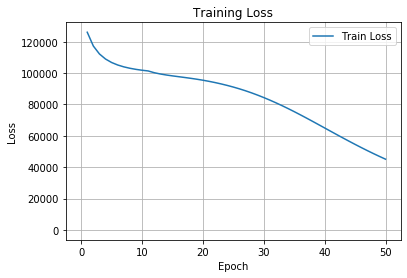

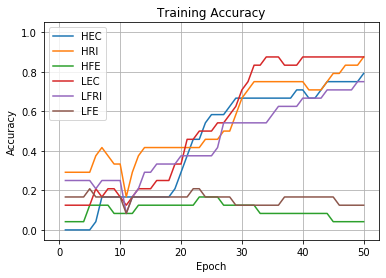

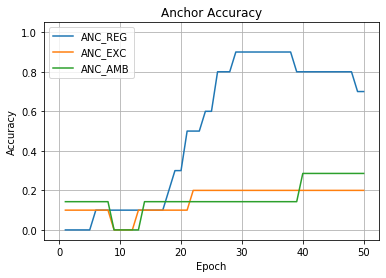

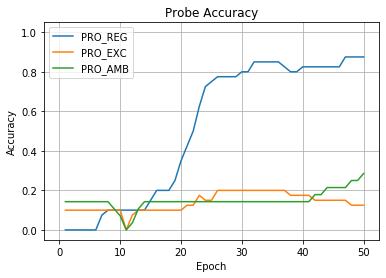

[EPOCH 50] 	 loss: 45105.769531 	 time: 1.6335 
[EPOCH 51] 	 loss: 43402.101562 	 time: 0.7530 
[EPOCH 52] 	 loss: 41766.375000 	 time: 0.6413 
[EPOCH 53] 	 loss: 40200.085938 	 time: 0.7333 
[EPOCH 54] 	 loss: 38704.003906 	 time: 0.6064 
[EPOCH 55] 	 loss: 37278.355469 	 time: 0.7367 
[EPOCH 56] 	 loss: 35922.492188 	 time: 0.5983 
[EPOCH 57] 	 loss: 34634.882812 	 time: 0.6159 
[EPOCH 58] 	 loss: 33413.265625 	 time: 0.7323 
[EPOCH 59] 	 loss: 32255.003906 	 time: 0.6038 
[EPOCH 60] 	 loss: 31157.414062 	 time: 0.7179 
[EPOCH 61] 	 loss: 30117.978516 	 time: 0.5809 
[EPOCH 62] 	 loss: 29134.318359 	 time: 0.7321 
[EPOCH 63] 	 loss: 28204.037109 	 time: 0.5996 
[EPOCH 64] 	 loss: 27324.574219 	 time: 0.7300 
[EPOCH 65] 	 loss: 26493.230469 	 time: 0.6007 
[EPOCH 66] 	 loss: 25707.181641 	 time: 0.6043 
[EPOCH 67] 	 loss: 24963.628906 	 time: 0.7365 
[EPOCH 68] 	 loss: 24260.210938 	 time: 0.6038 
[EPOCH 69] 	 loss: 23594.634766 	 time: 0.7304 
[EPOCH 70] 	 loss: 22964.724609 	 time: 

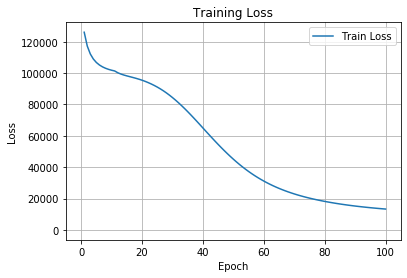

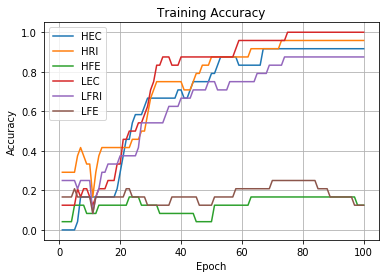

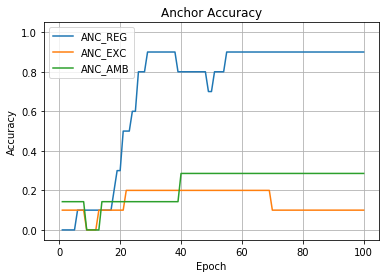

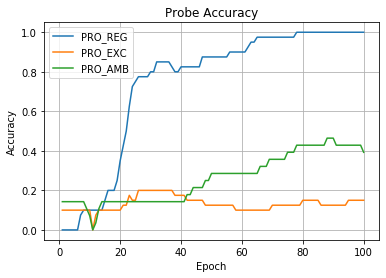

[EPOCH 100] 	 loss: 13303.875977 	 time: 1.6140 
[EPOCH 101] 	 loss: 13148.935547 	 time: 0.6417 
[EPOCH 102] 	 loss: 12999.357422 	 time: 0.7918 
[EPOCH 103] 	 loss: 12854.849609 	 time: 0.6416 
[EPOCH 104] 	 loss: 12715.142578 	 time: 0.7576 
[EPOCH 105] 	 loss: 12579.979492 	 time: 0.6146 
[EPOCH 106] 	 loss: 12449.114258 	 time: 0.7765 
[EPOCH 107] 	 loss: 12322.321289 	 time: 0.6144 
[EPOCH 108] 	 loss: 12199.357422 	 time: 0.7709 
[EPOCH 109] 	 loss: 12080.034180 	 time: 0.6571 
[EPOCH 110] 	 loss: 11964.150391 	 time: 0.6385 
[EPOCH 111] 	 loss: 11851.525391 	 time: 0.7809 
[EPOCH 112] 	 loss: 11741.997070 	 time: 0.6215 
[EPOCH 113] 	 loss: 11635.414062 	 time: 0.7532 
[EPOCH 114] 	 loss: 11531.654297 	 time: 0.6244 
[EPOCH 115] 	 loss: 11430.584961 	 time: 0.7896 
[EPOCH 116] 	 loss: 11332.072266 	 time: 0.6312 
[EPOCH 117] 	 loss: 11236.024414 	 time: 0.7824 
[EPOCH 118] 	 loss: 11142.316406 	 time: 0.6326 
[EPOCH 119] 	 loss: 11050.854492 	 time: 0.6531 
[EPOCH 120] 	 loss: 

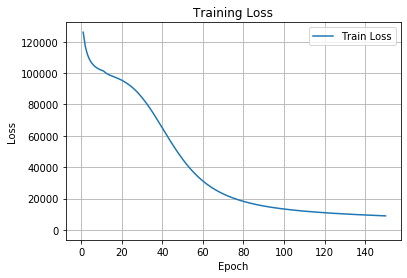

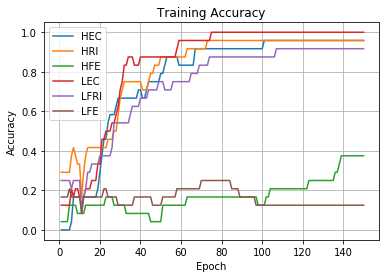

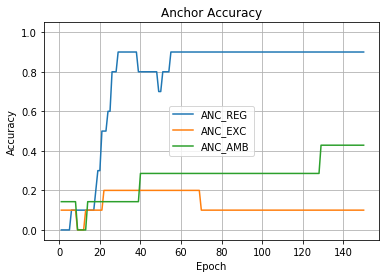

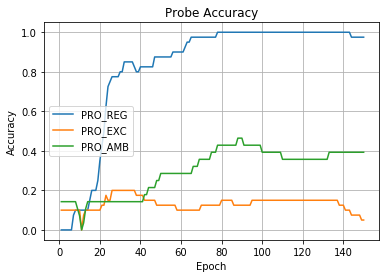

[EPOCH 150] 	 loss: 8958.621094 	 time: 1.6980 
[EPOCH 151] 	 loss: 8907.186523 	 time: 0.6266 
[EPOCH 152] 	 loss: 8856.425781 	 time: 0.6670 
[EPOCH 153] 	 loss: 8806.319336 	 time: 0.8212 
[EPOCH 154] 	 loss: 8756.850586 	 time: 0.6455 
[EPOCH 155] 	 loss: 8707.993164 	 time: 0.8115 
[EPOCH 156] 	 loss: 8659.723633 	 time: 0.6488 
[EPOCH 157] 	 loss: 8612.032227 	 time: 0.7887 
[EPOCH 158] 	 loss: 8564.891602 	 time: 0.6416 
[EPOCH 159] 	 loss: 8518.289062 	 time: 0.8092 
[EPOCH 160] 	 loss: 8472.201172 	 time: 0.6600 
[EPOCH 161] 	 loss: 8426.619141 	 time: 0.6734 
[EPOCH 162] 	 loss: 8381.517578 	 time: 0.8196 
[EPOCH 163] 	 loss: 8336.891602 	 time: 0.6634 
[EPOCH 164] 	 loss: 8292.715820 	 time: 0.8062 
[EPOCH 165] 	 loss: 8248.978516 	 time: 0.6606 
[EPOCH 166] 	 loss: 8205.666016 	 time: 0.8061 
[EPOCH 167] 	 loss: 8162.772461 	 time: 0.6620 
[EPOCH 168] 	 loss: 8120.272949 	 time: 0.8337 
[EPOCH 169] 	 loss: 8078.168457 	 time: 0.6751 
[EPOCH 170] 	 loss: 8036.435547 	 time: 

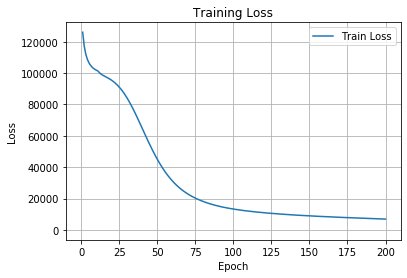

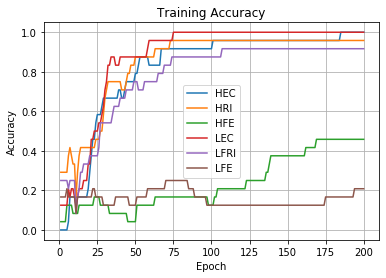

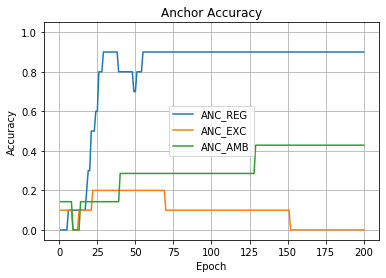

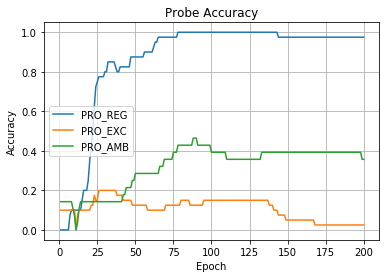

[EPOCH 200] 	 loss: 6918.471191 	 time: 1.7700 
[EPOCH 201] 	 loss: 6884.742188 	 time: 0.8375 
[EPOCH 202] 	 loss: 6851.197266 	 time: 0.6913 
[EPOCH 203] 	 loss: 6817.838379 	 time: 0.6943 
[EPOCH 204] 	 loss: 6784.664551 	 time: 0.8414 
[EPOCH 205] 	 loss: 6751.669922 	 time: 0.6963 
[EPOCH 206] 	 loss: 6718.854980 	 time: 0.8408 
[EPOCH 207] 	 loss: 6686.217285 	 time: 0.7135 
[EPOCH 208] 	 loss: 6653.755371 	 time: 0.8197 
[EPOCH 209] 	 loss: 6621.464355 	 time: 0.6869 
[EPOCH 210] 	 loss: 6589.343750 	 time: 0.9169 
[EPOCH 211] 	 loss: 6557.394043 	 time: 0.9332 
[EPOCH 212] 	 loss: 6525.611816 	 time: 0.8879 
[EPOCH 213] 	 loss: 6493.991211 	 time: 1.0280 
[EPOCH 214] 	 loss: 6462.542480 	 time: 0.8022 
[EPOCH 215] 	 loss: 6431.252930 	 time: 0.9602 
[EPOCH 216] 	 loss: 6400.125488 	 time: 0.7886 
[EPOCH 217] 	 loss: 6369.158691 	 time: 1.0278 
[EPOCH 218] 	 loss: 6338.349609 	 time: 0.7224 
[EPOCH 219] 	 loss: 6307.694824 	 time: 0.8908 
[EPOCH 220] 	 loss: 6277.197266 	 time: 

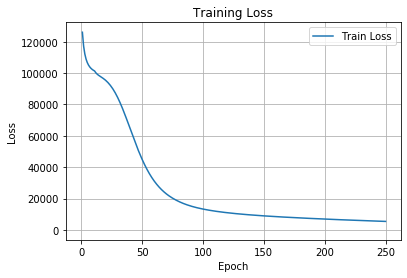

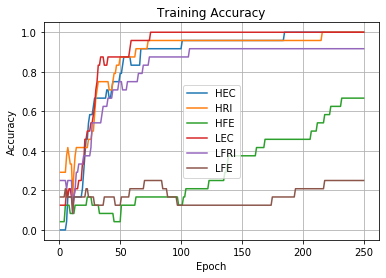

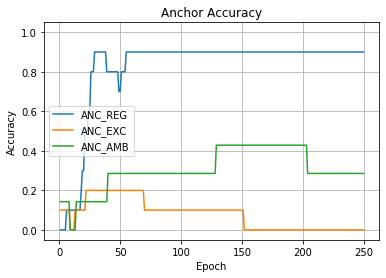

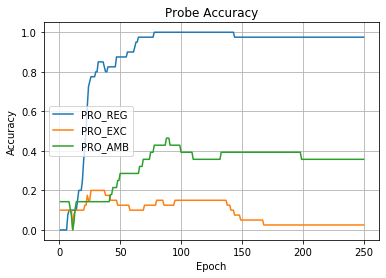

[EPOCH 250] 	 loss: 5428.585938 	 time: 2.2626 
[EPOCH 251] 	 loss: 5402.341797 	 time: 0.8896 
[EPOCH 252] 	 loss: 5376.218750 	 time: 1.0632 
[EPOCH 253] 	 loss: 5350.219727 	 time: 0.7513 
[EPOCH 254] 	 loss: 5324.345215 	 time: 0.9981 
[EPOCH 255] 	 loss: 5298.584961 	 time: 0.8638 
[EPOCH 256] 	 loss: 5272.948242 	 time: 0.8051 
[EPOCH 257] 	 loss: 5247.434570 	 time: 0.9426 
[EPOCH 258] 	 loss: 5222.033691 	 time: 0.7803 
[EPOCH 259] 	 loss: 5196.753906 	 time: 0.9802 
[EPOCH 260] 	 loss: 5171.593262 	 time: 0.8347 
[EPOCH 261] 	 loss: 5146.549316 	 time: 0.9944 
[EPOCH 262] 	 loss: 5121.623535 	 time: 0.7963 
[EPOCH 263] 	 loss: 5096.811035 	 time: 1.0436 
[EPOCH 264] 	 loss: 5072.117188 	 time: 0.7281 
[EPOCH 265] 	 loss: 5047.540527 	 time: 0.7241 
[EPOCH 266] 	 loss: 5023.076660 	 time: 0.9746 
[EPOCH 267] 	 loss: 4998.729492 	 time: 0.8813 
[EPOCH 268] 	 loss: 4974.495605 	 time: 1.0197 
[EPOCH 269] 	 loss: 4950.373047 	 time: 0.8794 
[EPOCH 270] 	 loss: 4926.368652 	 time: 

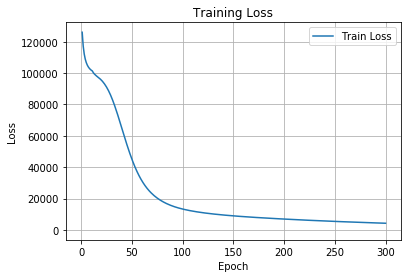

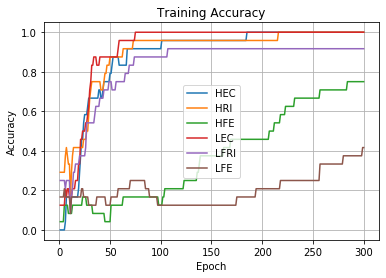

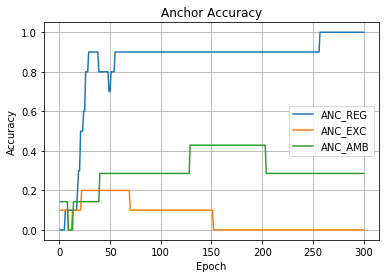

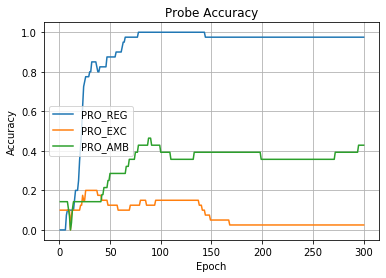

[EPOCH 300] 	 loss: 4257.555176 	 time: 2.0944 
[EPOCH 301] 	 loss: 4236.935059 	 time: 1.1493 
[EPOCH 302] 	 loss: 4216.418945 	 time: 0.9614 
[EPOCH 303] 	 loss: 4196.009766 	 time: 1.0580 
[EPOCH 304] 	 loss: 4175.702637 	 time: 0.8972 
[EPOCH 305] 	 loss: 4155.504395 	 time: 1.0964 
[EPOCH 306] 	 loss: 4135.408691 	 time: 0.8842 
[EPOCH 307] 	 loss: 4115.417969 	 time: 1.1473 
[EPOCH 308] 	 loss: 4095.531982 	 time: 0.8932 
[EPOCH 309] 	 loss: 4075.749512 	 time: 0.9092 
[EPOCH 310] 	 loss: 4056.067871 	 time: 0.9569 
[EPOCH 311] 	 loss: 4036.491943 	 time: 0.7958 
[EPOCH 312] 	 loss: 4017.018555 	 time: 0.9510 
[EPOCH 313] 	 loss: 3997.647949 	 time: 0.7852 
[EPOCH 314] 	 loss: 3978.379639 	 time: 1.0121 
[EPOCH 315] 	 loss: 3959.212646 	 time: 0.7756 
[EPOCH 316] 	 loss: 3940.149902 	 time: 0.9710 
[EPOCH 317] 	 loss: 3921.185059 	 time: 0.7825 
[EPOCH 318] 	 loss: 3902.322998 	 time: 0.7720 
[EPOCH 319] 	 loss: 3883.562256 	 time: 0.9703 
[EPOCH 320] 	 loss: 3864.901367 	 time: 

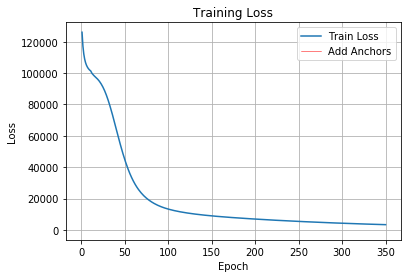

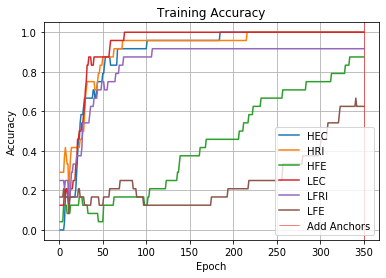

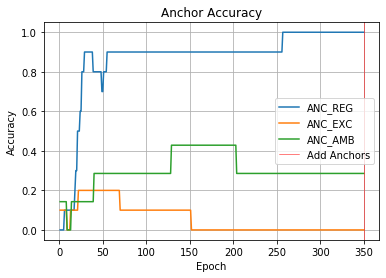

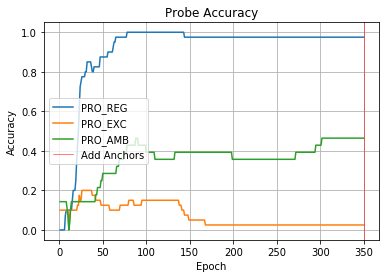

[EPOCH 350] 	 loss: 3349.978027 	 time: 2.6556 
[EPOCH 351] 	 loss: 1308.149658 	 time: 0.9375 
[EPOCH 352] 	 loss: 1269.998535 	 time: 0.8070 
[EPOCH 353] 	 loss: 1221.945190 	 time: 0.8155 
[EPOCH 354] 	 loss: 1189.901978 	 time: 1.1374 
[EPOCH 355] 	 loss: 1160.722534 	 time: 0.8819 
[EPOCH 356] 	 loss: 1131.203003 	 time: 1.3367 
[EPOCH 357] 	 loss: 1106.069336 	 time: 0.8630 
[EPOCH 358] 	 loss: 1086.172729 	 time: 1.3008 
[EPOCH 359] 	 loss: 1067.453979 	 time: 0.8307 
[EPOCH 360] 	 loss: 1047.690552 	 time: 0.9972 
[EPOCH 361] 	 loss: 1029.586060 	 time: 0.8423 
[EPOCH 362] 	 loss: 1014.755310 	 time: 0.8161 
[EPOCH 363] 	 loss: 1001.051758 	 time: 0.9869 
[EPOCH 364] 	 loss: 986.441772 	 time: 0.7908 
[EPOCH 365] 	 loss: 971.647766 	 time: 0.9578 
[EPOCH 366] 	 loss: 958.047668 	 time: 0.7973 
[EPOCH 367] 	 loss: 945.522034 	 time: 1.0053 
[EPOCH 368] 	 loss: 933.007263 	 time: 1.0168 
[EPOCH 369] 	 loss: 920.175293 	 time: 1.1110 
[EPOCH 370] 	 loss: 907.588867 	 time: 0.9054 

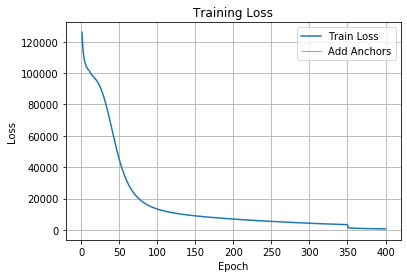

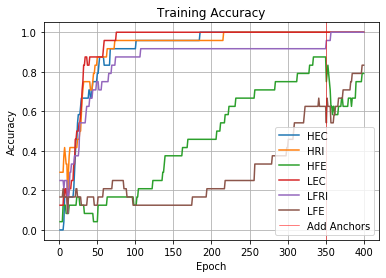

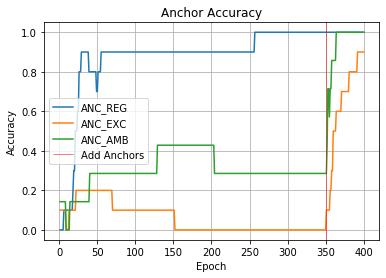

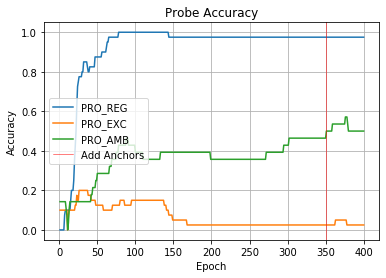

[EPOCH 400] 	 loss: 637.953186 	 time: 2.1430 
[EPOCH 401] 	 loss: 631.140198 	 time: 0.7596 
[EPOCH 402] 	 loss: 624.425415 	 time: 1.0490 
[EPOCH 403] 	 loss: 617.790161 	 time: 0.7958 
[EPOCH 404] 	 loss: 611.233704 	 time: 0.8222 
[EPOCH 405] 	 loss: 604.773499 	 time: 1.2254 
[EPOCH 406] 	 loss: 598.405457 	 time: 0.9246 
[EPOCH 407] 	 loss: 592.108459 	 time: 1.0965 
[EPOCH 408] 	 loss: 585.879883 	 time: 0.9589 
[EPOCH 409] 	 loss: 579.732910 	 time: 1.1736 
[EPOCH 410] 	 loss: 573.668579 	 time: 0.8425 
[EPOCH 411] 	 loss: 567.673767 	 time: 1.0528 
[EPOCH 412] 	 loss: 561.742065 	 time: 0.8630 
[EPOCH 413] 	 loss: 555.881897 	 time: 0.8573 
[EPOCH 414] 	 loss: 550.097351 	 time: 0.9892 
[EPOCH 415] 	 loss: 544.380615 	 time: 0.7846 
[EPOCH 416] 	 loss: 538.725769 	 time: 1.0154 
[EPOCH 417] 	 loss: 533.138306 	 time: 0.8607 
[EPOCH 418] 	 loss: 527.620422 	 time: 1.0121 
[EPOCH 419] 	 loss: 522.165833 	 time: 0.8219 
[EPOCH 420] 	 loss: 516.771484 	 time: 1.0999 
[EPOCH 421] 	

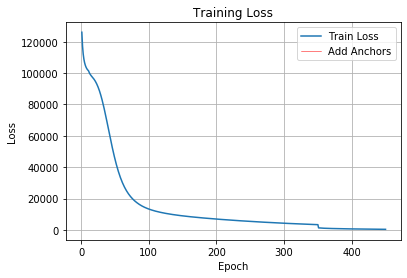

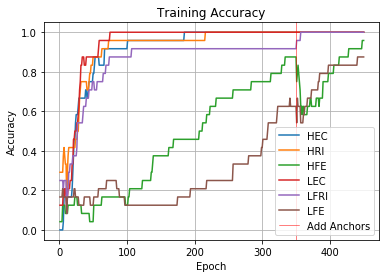

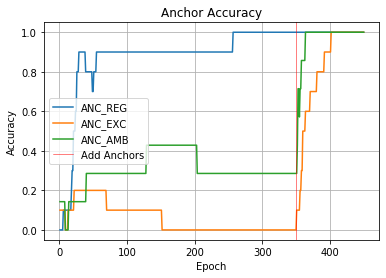

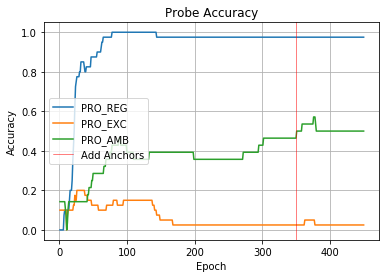

[EPOCH 450] 	 loss: 380.577057 	 time: 1.8749 
[EPOCH 451] 	 loss: 376.790588 	 time: 0.9208 
[EPOCH 452] 	 loss: 373.047516 	 time: 0.8642 
[EPOCH 453] 	 loss: 369.347229 	 time: 1.0766 
[EPOCH 454] 	 loss: 365.689484 	 time: 0.8931 
[EPOCH 455] 	 loss: 362.073761 	 time: 1.1420 
[EPOCH 456] 	 loss: 358.499817 	 time: 0.8576 
[EPOCH 457] 	 loss: 354.967010 	 time: 0.8779 
[EPOCH 458] 	 loss: 351.474915 	 time: 1.0310 
[EPOCH 459] 	 loss: 348.023621 	 time: 0.8864 
[EPOCH 460] 	 loss: 344.612396 	 time: 1.0303 
[EPOCH 461] 	 loss: 341.240997 	 time: 0.8867 
[EPOCH 462] 	 loss: 337.909210 	 time: 1.1184 
[EPOCH 463] 	 loss: 334.616516 	 time: 0.8450 
[EPOCH 464] 	 loss: 331.362885 	 time: 1.0894 
[EPOCH 465] 	 loss: 328.147797 	 time: 0.8620 
[EPOCH 466] 	 loss: 324.971039 	 time: 0.8622 
[EPOCH 467] 	 loss: 321.832336 	 time: 1.0428 
[EPOCH 468] 	 loss: 318.731506 	 time: 0.8622 
[EPOCH 469] 	 loss: 315.667969 	 time: 1.0396 
[EPOCH 470] 	 loss: 312.641693 	 time: 0.8752 
[EPOCH 471] 	

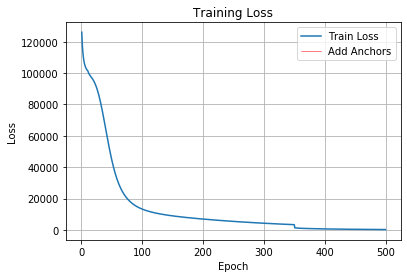

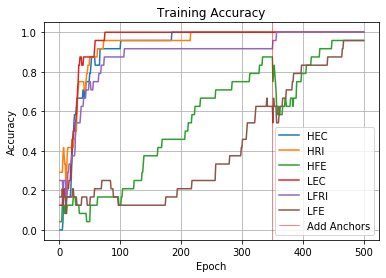

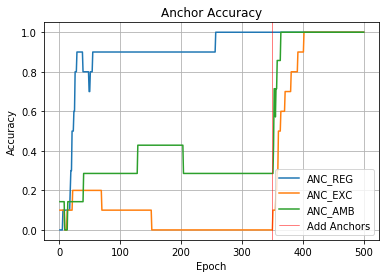

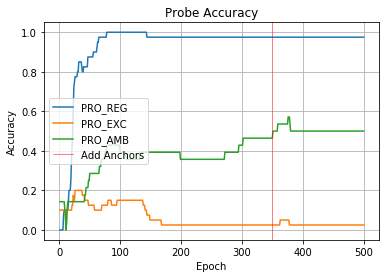

[EPOCH 500] 	 loss: 237.253235 	 time: 2.1643 
[EPOCH 501] 	 loss: 235.190338 	 time: 0.7773 
[EPOCH 502] 	 loss: 233.152618 	 time: 1.0725 
[EPOCH 503] 	 loss: 231.139893 	 time: 0.8915 
[EPOCH 504] 	 loss: 229.151749 	 time: 1.1062 
[EPOCH 505] 	 loss: 227.188049 	 time: 0.9352 
[EPOCH 506] 	 loss: 225.248260 	 time: 1.1589 
[EPOCH 507] 	 loss: 223.332123 	 time: 0.9028 
[EPOCH 508] 	 loss: 221.439529 	 time: 0.9081 
[EPOCH 509] 	 loss: 219.570007 	 time: 1.0780 
[EPOCH 510] 	 loss: 217.723129 	 time: 0.8944 
[EPOCH 511] 	 loss: 215.898956 	 time: 1.0904 
[EPOCH 512] 	 loss: 214.096970 	 time: 0.9138 
[EPOCH 513] 	 loss: 212.316849 	 time: 1.1662 
[EPOCH 514] 	 loss: 210.558487 	 time: 0.9458 
[EPOCH 515] 	 loss: 208.821411 	 time: 1.1669 
[EPOCH 516] 	 loss: 207.105423 	 time: 0.9156 
[EPOCH 517] 	 loss: 205.410248 	 time: 0.8917 
[EPOCH 518] 	 loss: 203.735596 	 time: 1.0829 
[EPOCH 519] 	 loss: 202.081238 	 time: 0.8858 
[EPOCH 520] 	 loss: 200.446930 	 time: 1.0704 
[EPOCH 521] 	

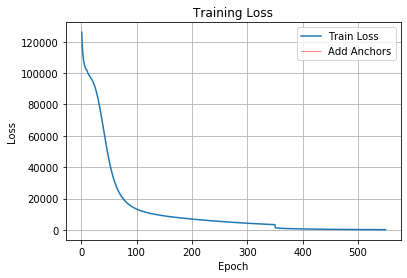

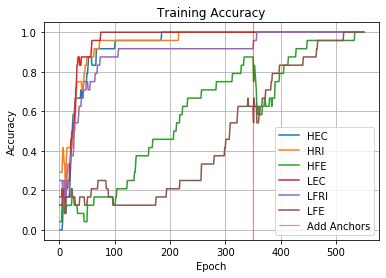

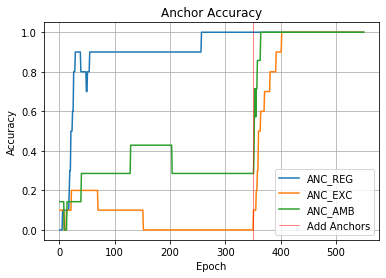

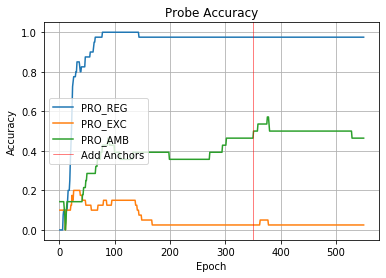

[EPOCH 550] 	 loss: 159.531281 	 time: 1.9383 
[EPOCH 551] 	 loss: 158.402252 	 time: 1.0081 
[EPOCH 552] 	 loss: 157.286346 	 time: 0.9295 
[EPOCH 553] 	 loss: 156.183365 	 time: 1.1185 
[EPOCH 554] 	 loss: 155.093155 	 time: 0.9465 
[EPOCH 555] 	 loss: 154.015503 	 time: 1.2222 
[EPOCH 556] 	 loss: 152.950302 	 time: 0.9881 
[EPOCH 557] 	 loss: 151.897308 	 time: 1.2222 
[EPOCH 558] 	 loss: 150.856491 	 time: 0.9561 
[EPOCH 559] 	 loss: 149.827606 	 time: 0.9828 
[EPOCH 560] 	 loss: 148.810440 	 time: 1.1158 
[EPOCH 561] 	 loss: 147.804977 	 time: 0.9802 
[EPOCH 562] 	 loss: 146.810913 	 time: 1.1440 
[EPOCH 563] 	 loss: 145.828262 	 time: 0.9785 
[EPOCH 564] 	 loss: 144.856750 	 time: 1.1721 
[EPOCH 565] 	 loss: 143.896286 	 time: 0.9439 
[EPOCH 566] 	 loss: 142.946701 	 time: 1.1911 
[EPOCH 567] 	 loss: 142.007874 	 time: 0.9386 
[EPOCH 568] 	 loss: 141.079697 	 time: 0.9256 
[EPOCH 569] 	 loss: 140.161911 	 time: 1.1434 
[EPOCH 570] 	 loss: 139.254517 	 time: 0.9427 
[EPOCH 571] 	

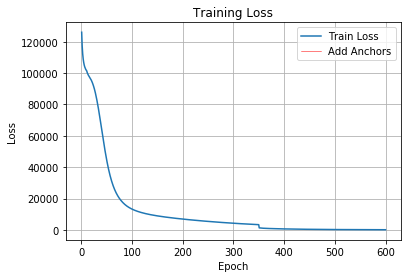

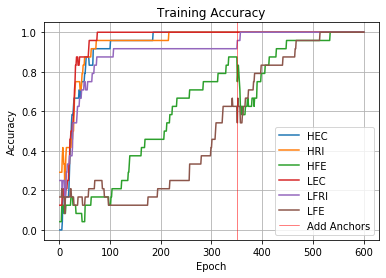

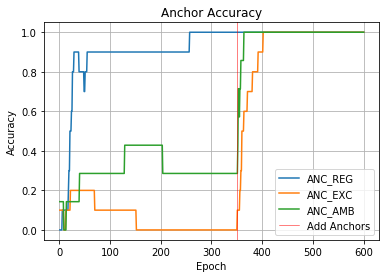

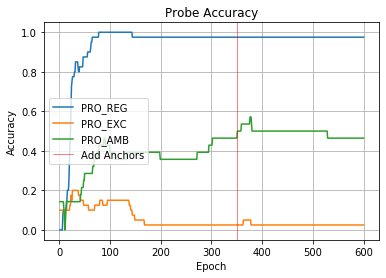

[EPOCH 600] 	 loss: 116.229515 	 time: 2.2803 
[EPOCH 601] 	 loss: 115.583725 	 time: 0.8386 
[EPOCH 602] 	 loss: 114.944801 	 time: 1.1823 
[EPOCH 603] 	 loss: 114.312553 	 time: 0.9696 
[EPOCH 604] 	 loss: 113.686928 	 time: 1.0833 
[EPOCH 605] 	 loss: 113.067886 	 time: 0.9469 
[EPOCH 606] 	 loss: 112.455284 	 time: 1.2907 
[EPOCH 607] 	 loss: 111.849060 	 time: 0.9770 
[EPOCH 608] 	 loss: 111.249146 	 time: 1.2465 
[EPOCH 609] 	 loss: 110.655434 	 time: 0.9704 
[EPOCH 610] 	 loss: 110.067886 	 time: 0.9982 
[EPOCH 611] 	 loss: 109.486374 	 time: 1.1605 
[EPOCH 612] 	 loss: 108.910858 	 time: 0.9957 
[EPOCH 613] 	 loss: 108.341270 	 time: 1.1981 
[EPOCH 614] 	 loss: 107.777473 	 time: 1.0141 
[EPOCH 615] 	 loss: 107.219482 	 time: 1.2530 
[EPOCH 616] 	 loss: 106.667145 	 time: 0.9685 
[EPOCH 617] 	 loss: 106.120392 	 time: 1.2618 
[EPOCH 618] 	 loss: 105.579231 	 time: 0.9713 
[EPOCH 619] 	 loss: 105.043533 	 time: 0.9957 
[EPOCH 620] 	 loss: 104.513229 	 time: 1.1632 
[EPOCH 621] 	

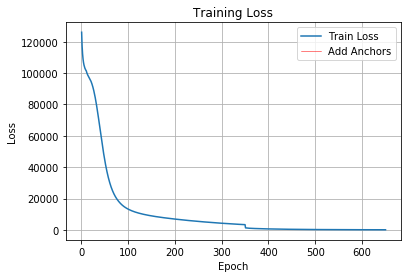

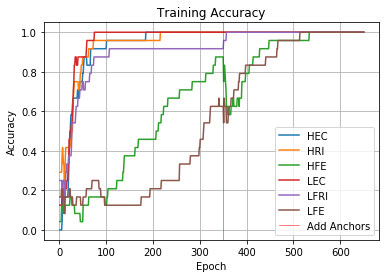

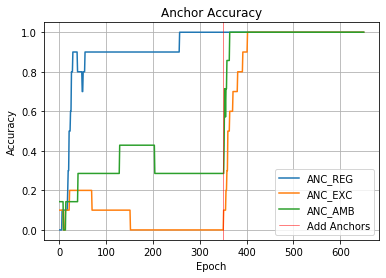

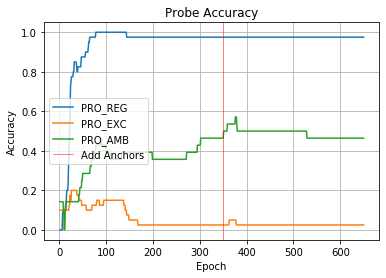

[EPOCH 650] 	 loss: 90.812119 	 time: 2.6543 
[EPOCH 651] 	 loss: 90.419922 	 time: 0.8576 
[EPOCH 652] 	 loss: 90.031418 	 time: 0.9870 
[EPOCH 653] 	 loss: 89.646469 	 time: 1.1736 
[EPOCH 654] 	 loss: 89.265076 	 time: 0.9220 
[EPOCH 655] 	 loss: 88.887192 	 time: 1.2378 
[EPOCH 656] 	 loss: 88.512794 	 time: 1.0476 
[EPOCH 657] 	 loss: 88.141823 	 time: 1.2102 
[EPOCH 658] 	 loss: 87.774269 	 time: 1.0007 
[EPOCH 659] 	 loss: 87.410042 	 time: 1.2704 
[EPOCH 660] 	 loss: 87.049133 	 time: 0.9799 
[EPOCH 661] 	 loss: 86.691483 	 time: 1.2575 
[EPOCH 662] 	 loss: 86.337082 	 time: 0.9979 
[EPOCH 663] 	 loss: 85.985870 	 time: 1.0016 
[EPOCH 664] 	 loss: 85.637848 	 time: 1.1607 
[EPOCH 665] 	 loss: 85.292915 	 time: 0.9567 
[EPOCH 666] 	 loss: 84.951065 	 time: 1.2307 
[EPOCH 667] 	 loss: 84.612297 	 time: 0.9859 
[EPOCH 668] 	 loss: 84.276520 	 time: 1.2754 
[EPOCH 669] 	 loss: 83.943756 	 time: 0.9989 
[EPOCH 670] 	 loss: 83.613914 	 time: 1.2693 
[EPOCH 671] 	 loss: 83.286980 	 ti

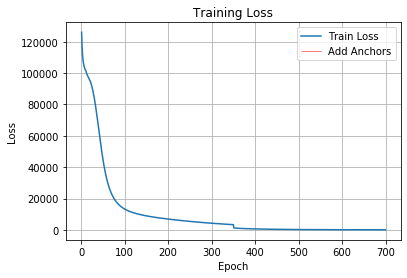

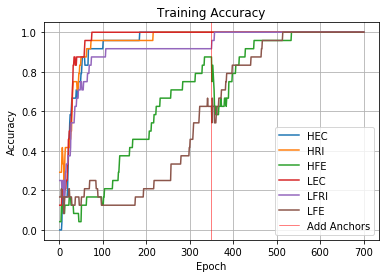

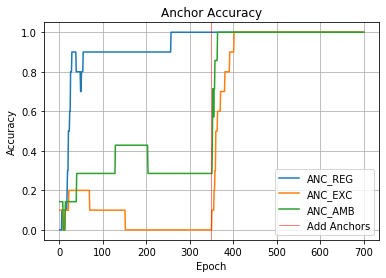

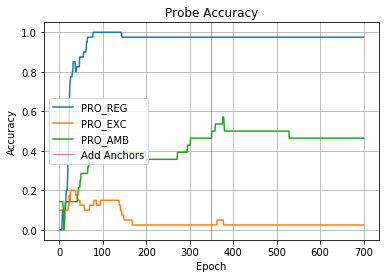

[EPOCH 700] 	 loss: 74.936958 	 time: 2.3318 


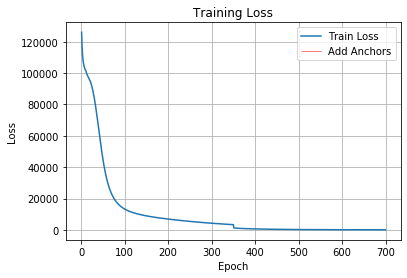

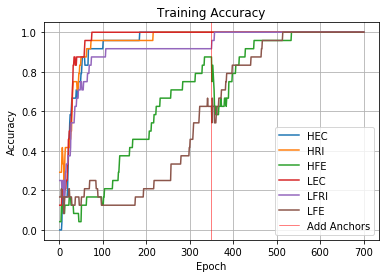

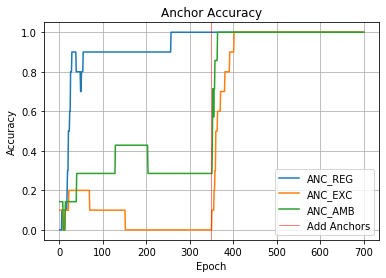

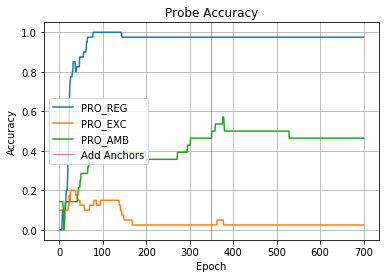

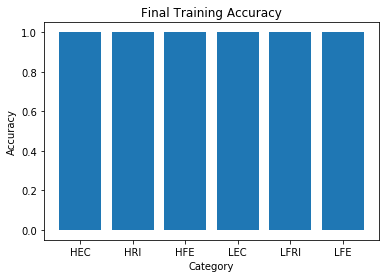

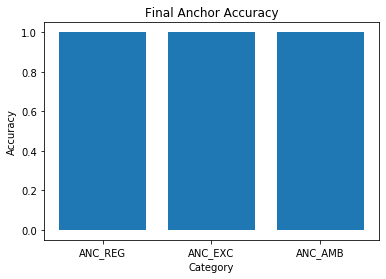

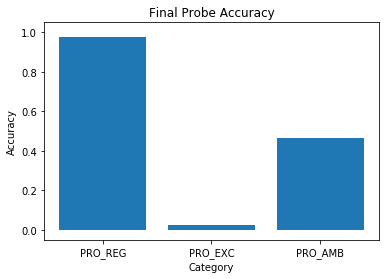

Average Time per epoch:  0.9383717955861772
Training Completed!
Add any notes below to save with results:
 > 
Simulation results saved.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from simulator import *
sim = simulator()
sim.train()

In [0]:
def train(model, plaut_loader, plaut_anc_loader, anc_loader, probe_loader, folder, lr=0.001):
    # define loss function and optimizer
    criterion = nn.BCELoss(reduction='none')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Initialize arrays to store epochs, train loss
    epochs, losses = [], []
    
    # Select word types to calculate accuracy for
    types = ["HEC", "HRI", "HFE", "LEC", "LFRI", "LFEEXPT"] # calculate accuracy of these types
    anc_types = ["ANC_REG", "ANC_EXC", "ANC_AMB"]
    probe_types = ["PRO_REG", "PRO_EXC", "PRO_AMB"]
    
    # Initialize arrays to store accuracy of plaut dataset, anchors, probes
    acc = [[], [], [], []]
    anc_acc = [[] for i in anc_types]
    probe_acc = [[] for i in probe_types]
    
    for epoch in range(600):
        if epoch < 500: # use only plaut dataset for first 500 epochs
            data_loader = plaut_loader
        else: # after, train with both plaut + anchors
            data_loader = plaut_anc_loader
        
        avg_loss = 0 # initialize avg loss
        for i, data in enumerate(data_loader): 
            # extract frequency, inputs, labels
            freq = data["frequency"].float().view(-1, 1) # reshape to [batch_size x 1] to match output size
            inputs = data["graphemes"].float()
            labels = data["phonemes"].float()
            
            #forward pass + backward pass + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = (loss*freq).mean() # scale loss by frequency, then find mean
            avg_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # calculate loss and save loss to array
        losses.append(avg_loss)
        epochs.append(epoch+1)
        
        # calculate accuracy over the different types for plaut dataset
        temp_acc = get_accuracy(model, plaut_loader, types)
        acc[0].append((temp_acc[0]+temp_acc[1])/2) # average of HFR consistent and inconsistent
        acc[1].append(temp_acc[2]) # HFE
        acc[2].append((temp_acc[3]+temp_acc[4])/2) # average of LFR consistent and inconsistent
        acc[3].append(temp_acc[5]) # LFE
        
        # calculate accuracy over the different types for anchors
        temp_acc = get_accuracy(model, anc_loader, anc_types, vowels_only=True)
        for i in range(len(anc_types)):
            anc_acc[i].append(temp_acc[i])
            
        # calculate accuracy over the different types for probes
        temp_acc = get_accuracy(model, probe_loader, probe_types, vowels_only=True)
        for i in range(len(probe_types)):
            probe_acc[i].append(temp_acc[i])
        
        # print stats every 5 epochs
        if epoch % 1 == 0:
            print("[EPOCH %d] loss: %.6f" % (epoch+1, avg_loss))
        
        # plot loss every 5 epochs
        if epoch % 50 == 49:
            make_plot(epochs, [losses], ["Train Loss"], "Epoch", "Loss", "Training Loss")
            make_plot(epochs, acc, ["HFR", "HFE", "LFR", "LFE"], "Epoch", "Accuracy", "Training Accuracy")
            make_plot(epochs, anc_acc, anc_types, "Epoch", "Accuracy", "Anchor Accuracy")
            make_plot(epochs, probe_acc, probe_types, "Epoch", "Accuracy", "Probe Accuracy")
            

    # plot final loss curve and save
    plt.figure()
    plt.title("Training Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(losses, label="Training Loss")
    plt.savefig(rootdir+"/lossplot_final.png", dpi=150)
    plt.close()

### Training

In [0]:
# create a new folder for every run
path = Path(os.getcwd()).parent #get parent (Plaut_Model) directory filepath
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = str(path)+"/results/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1


print("Test Results saved in :", rootdir)

torch.manual_seed(1) # initialize random seed
model = plaut_net() # initialize model
train(model, plaut_loader, plaut_anc_loader, anc_loader, probe_loader, rootdir, lr=0.1) # train!!!!

In [0]:
# obtain list of categories in dataset, and add "All" for overall accuracy
types = list(plaut_ds.df["type"].unique())
types.append("All")
    
accuracy = get_accuracy(model, plaut_loader, types)


# plot in bar graph
plt.bar(types, accuracy)
plt.xticks(rotation='vertical')
plt.xlabel("Type")
plt.ylabel("Accuracy")
plt.title("Accuracy by Type")
plt.savefig("../test/"+rootdir+"/accuracy_chart_final.png", dpi=150)
plt.show()


In [0]:
# function to get the accuracy of a particular category
def get_accuracy2 (model, train_loader, cat='All'):
    correct = 0
    total = 0
    for i, data in enumerate (train_loader): # get batch from dataloader
        # extract inputs, labels, type from batch
        inputs = data["graphemes"].float()
        labels = data["phonemes"].float()
        types = pd.DataFrame(data["type"])
        
        outputs = model(inputs) # find prediction using model
        outputs = outputs.round() # round output to 0 or 1
        compare = torch.eq(outputs, labels).sum(dim=1) # compare with labels
        
        if cat == 'All':
            correct += torch.eq(compare, 61).sum().item() # count as correct if all 61 elements match label
            total += len(compare)
        else:
            types = types.apply(lambda x: x == cat) # check for desired type
            compare = pd.DataFrame(compare)
            correct += ((types == True) & (compare == 61)).sum()[0] # count as correct if desired type AND all 61 elements match total
            total += (types==True).sum()[0] # count all of the desired type
    
    return correct/(total) # return accuracy

In [0]:
def get_accuracy_vowels (model, train_loader, cat=['REG', 'EXC', 'AMB']):
    correct = [0, 0, 0]
    total = [0, 0, 0]
    for i, data in enumerate (train_loader):
        inputs = data["graphemes"].float()
        labels = data["phonemes"].float()
        labels = labels[:, len(phoneme_onset):len(phoneme_onset)+len(phoneme_vowel)]
        
        outputs = model(inputs)
        outputs = outputs[:, len(phoneme_onset):len(phoneme_onset)+len(phoneme_vowel)]
        outputs = torch.sigmoid(outputs).round()
        compare = torch.eq(outputs, labels).sum(dim=1)
        for i in range(len(cat)):
            types = pd.DataFrame(data["type"])
            #print(types)
            types = types.apply(lambda x: x == cat[i])
            #print(types)
            #break
            compare = pd.DataFrame(compare)
            correct[i] += ((types == True) & (compare == len(phoneme_vowel))).sum()[0]
            total[i] += (types==True).sum()[0]
    return correct, total